In [6]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import recommendations
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [7]:
df = pd.read_csv('../datasets/SEHIR/processed_dataset.csv')
df = df[['Student Number', 'Course Code', 'Letter Grade', 'Semester', 'Course Credit', 'GPA', 'Completed Credits', 'Department Code']]
df

,Student Number,Course Code,Letter Grade,Semester,Course Credit,GPA,Completed Credits,Department Code
0,240,UNI 111,F,2011 - Fall,3,2.62,18,SOC
1,338,UNI 107,A,2011 - Fall,3,3.68,18,PSY
2,338,UNI 105,A,2011 - Fall,3,3.68,18,PSY
3,338,UNI 103,A,2011 - Fall,3,3.68,18,PSY
4,240,UNI 105,A,2011 - Fall,3,2.62,18,SOC
...,...,...,...,...,...,...,...,...
48736,1102,MGT 531,A-,2014 - Spring,3,3.80,24,MBA/NT
48737,1102,MGT 585,A,2014 - Spring,3,3.80,24,MBA/NT
48738,1102,MGT 552,A,2014 - Spring,3,3.80,24,MBA/NT
48739,1984,MGT 574,A-,2014 - Spring,3,3.20,24,MBA/NT


In [8]:
df = pd.concat([df, pd.get_dummies(df['Department Code'], prefix='Department Code')], axis=1)
df.drop(['Department Code'], axis=1, inplace=True)

In [9]:
numerical_grades = {'A+': 4.1, 'A': 4.0, 'A-': 3.7, 'B+': 3.3, 'B': 3.0, 'B-': 2.7, 'C+': 2.3, 'C': 2.0,
                    'C-': 1.7, 'D+': 1.3, 'D': 1.0, 'D-': 0.5, 'F': 0.0}

In [10]:
course_credits = {}
for row_idx in df.index:
    course_code = df.iloc[row_idx, 1]
    credit = df.iloc[row_idx, 4]    
    course_credits[course_code] = credit

In [11]:
def get_semester_data(semester_name):
    semester_data = {}   # semester data in shape {student_number: {course_code: letter_grade, ...}, ...}
    
    # extracting the instances with the given semester_name from the main dataFrame
    dataset = df[df.iloc[:, 3] == semester_name]
    dataset.index = range(len(dataset))
    
    # filling the semester_data dictionary
    for row_idx in dataset.index:
        student_number = dataset.iloc[row_idx, 0]
        course_code = dataset.iloc[row_idx, 1]
        letter_grade = dataset.iloc[row_idx, 2]
        
        semester_data.setdefault(student_number, {})
        semester_data[student_number][course_code] = numerical_grades[letter_grade]
    
    return semester_data

#### Sparsity Ratio per Semester

In [11]:
def sparsity_ratio_semester(semester_data):
    students = list(semester_data.keys())
    
    # all courses appearing in this semester
    all_courses = set()
    for courses in semester_data.values():
        all_courses.update(courses.keys())
    
    num_students = len(students)
    num_courses = len(all_courses)
    
    observed = sum(len(courses) for courses in semester_data.values())
    total_possible = num_students * num_courses
    
    sparsity = 1 - (observed / total_possible)
    
    return sparsity, observed, total_possible

In [12]:
def sparsity_ratio_semester_feasible(semester_data, df, semester_name):
    dataset = df[df.iloc[:, 3] == semester_name]
    
    total_possible = 0
    observed = 0

    for student in semester_data:
        student_courses = semester_data[student].keys()
        offered_courses = set(
            dataset[dataset.iloc[:, 0] == student].iloc[:, 1]
        )

        total_possible += len(offered_courses)
        observed += len(student_courses)

    sparsity = 1 - (observed / total_possible)
    return sparsity

In [12]:
def get_avg_gpa(train_semester, student):
    courses = train_semester[student]
    total_credit = 0
    weights = 0
    for course in courses:
        total_credit += course_credits[course]
        weights += courses[course] * course_credits[course]
    
    return weights / total_credit

In [13]:
def get_grade_stats(semester_data, student):
    grade_list = []
    
    for course in semester_data[student]:
        numerical_grade = semester_data[student][course]
        grade_list.append(numerical_grade)
    
    mean = np.mean(grade_list)
    std_dev = np.std(grade_list)
    
    return mean, std_dev

In [15]:
def elbow_inertia(train_sems, cluster_model, k_range=range(10, 31, 5)):
    train_dataset = pd.DataFrame(columns=df.columns)

    # build training dataset (same as fit_cluster)
    for sem in train_sems:
        train_dataset = pd.concat(
            [train_dataset, df[df.iloc[:, 3] == sem]],
            ignore_index=True
        )

    cluster_features = train_dataset[['GPA', 'Completed Credits'] +
                                     list(train_dataset.columns[7:])]

    inertias = []

    for k in k_range:
        kmeans = cluster_model(
            n_clusters=k,
            random_state=42,
            n_init=10
        )
        kmeans.fit(cluster_features)
        inertias.append(kmeans.inertia_)

    return list(k_range), inertias

In [14]:
def fit_cluster(train_sems, num_clusters, training_data, cluster_model):
    train_dataset = pd.DataFrame(columns=df.columns)
    
    # extracting instances from the dataset which should be in training data
    for sem in train_sems:
        train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)

    cluster_features = train_dataset[['GPA', 'Completed Credits'] + list(train_dataset.columns[7:])]
    
    # fitting a clustering model based on GPA, Completed Credits and Departments
    fitted_cluster_model = cluster_model(n_clusters=num_clusters).fit(cluster_features)
    cluster_labels = fitted_cluster_model.labels_

    # Silhouette metrics
    sil_score = silhouette_score(cluster_features, cluster_labels)

    sil_samples = silhouette_samples(cluster_features, cluster_labels)
    cluster_silhouette = {}

    for lbl in np.unique(cluster_labels):
        cluster_silhouette[lbl] = sil_samples[cluster_labels == lbl].mean()
    
    cluster_dataset = {}   # splitting the train dataset into sub-dicts based on their predicted cluster label
    
    # assigning each students' data to their predicted clusters
    for i in range(len(cluster_labels)):
        cluster_dataset.setdefault(cluster_labels[i], {})
        student_number = train_dataset.iloc[i, 0]
        cluster_dataset[cluster_labels[i]][student_number] = training_data[student_number]
    
    return cluster_dataset, fitted_cluster_model, sil_score, cluster_silhouette

In [15]:
def cluster_test_data(cluster_model, semester_name):
    # extracting all instances with the given semester_name from the main dataFrame
    test_dataset = df[df.iloc[:, 3] == semester_name]
    test_dataset.index = range(len(test_dataset))
    
    # predicting the cluster labels of test data using a cluster model fitted on the train data so far
    cluster_features = test_dataset[['GPA', 'Completed Credits'] + list(test_dataset.columns[7:])]
    cluster_labels = cluster_model.predict(cluster_features)
    
    # getting the semester data of available students in test semester
    semester_data = get_semester_data(semester_name)
    
    cluster_dataset = {}   # splitting the test dataset into sub-dicts based on their predicted cluster label
    
    # assigning each students' data to their predicted clusters
    for i in range(len(cluster_labels)):
        cluster_dataset.setdefault(cluster_labels[i], {})
        student_number = test_dataset.iloc[i, 0]
        cluster_dataset[cluster_labels[i]][student_number] = semester_data[student_number]
        
    return cluster_dataset    

In [16]:
# yeni eklendi 
def get_course_stats(train_semester):
    course_grades = {}
    all_grades = []
    for student, courses in train_semester.items():
        for course, grade in courses.items():
            course_grades.setdefault(course, []).append(grade)
            all_grades.append(grade)
    course_means = {c: np.mean(g) for c, g in course_grades.items()}
    global_mean = np.mean(all_grades) if all_grades else 0
    return course_means, global_mean

In [29]:
# yeni hali 
def get_errors(train_semester, test_semester, sim, item_based, fallback_strategy='student'): # Varsayılan 'student' kalsın
    average_gpa = {}
    y_true = []
    y_pred = []
    gpa = {}
    
    # Hazırlık
    if fallback_strategy == 'course':
        course_means, global_mean = get_course_stats(train_semester)

    for student in train_semester:
        gpa[student] = get_avg_gpa(train_semester, student)
    
    if item_based: # item_sims hesabı gerekliyse
        item_sims = recommendations.calculateSimilarItems(train_semester)

    for student in train_semester:
        recommended_courses = {}
        
        if item_based:
            recs = recommendations.getRecommendedItems(train_semester, item_sims, student)
        else:
            recs = recommendations.getRecommendations(train_semester, student, sim, dgpa=True, gpa=gpa, delta=0.7)
        
        # print(f"recs {recs}")

        for rec_grade, rec_course in recs:
            recommended_courses.setdefault(rec_course, rec_grade)
            
        average_gpa.setdefault(student, get_avg_gpa(train_semester, student))
        
        if student not in test_semester:
            continue
        
        # Outlier kontrolü için öğrenci istatistikleri
        mean, std_dev = get_grade_stats(train_semester, student)
            
        for course_code in test_semester[student]:
            if course_code in recommended_courses:
                rec_grade = recommended_courses[course_code]
            else:
                # FALLBACK MEKANİZMASI
                if fallback_strategy == 'course':
                    rec_grade = course_means.get(course_code, global_mean)
                else:
                    rec_grade = average_gpa[student]

            # Outlier (Aykırı Değer) Kontrolü
            if rec_grade < mean - (2 * std_dev) or rec_grade > mean + (2 * std_dev):
                continue
            
            y_pred.append(rec_grade)
            y_true.append(test_semester[student][course_code])
            
    assert len(y_true) == len(y_pred)   
    return y_true, y_pred

In [28]:
# yeni algo icin 
def get_errors(train_semester, test_semester, sim, item_based, sim_matrix=None, model_type='local'):
    average_gpa = {}
    y_true = []
    y_pred = []
    sources = []  # <--- YENİ: Kaynakları tutacak liste
    gpa = {}
    
    # 1. GPA Hazırlığı
    for student in train_semester:
        gpa[student] = get_avg_gpa(train_semester, student)
        average_gpa[student] = gpa[student]

    # 2. Benzerlik Matrisi
    current_sims = sim_matrix
    if item_based and current_sims is None:
        current_sims = recommendations.calculateSimilarItems(train_semester)

    # 3. Tahmin Döngüsü
    for student in train_semester:
        if student not in test_semester: continue

        # --- CF ÖNERİLERİ ---
        recommended_courses = {}
        if item_based:
            recs = recommendations.getRecommendedItems(train_semester, current_sims, student)
        else:
            recs = recommendations.getRecommendations(train_semester, student, sim, dgpa=True, gpa=gpa, delta=0.7)
        
        for rec_grade, rec_course in recs:
            recommended_courses[rec_course] = rec_grade
            
        mean, std_dev = get_grade_stats(train_semester, student)
            
        for course_code in test_semester[student]:
            final_pred = None
            source_tag = "" # <--- Etiket
            
            # DURUM 1: CF Tahmini (Local veya Global)
            if course_code in recommended_courses:
                final_pred = recommended_courses[course_code]
                source_tag = "CF" # (İstersen f"{model_type}_CF" diyerek Local/Global ayırabilirsin)
            
            # DURUM 2: Fallback (GPA)
            else:
                final_pred = average_gpa[student]
                source_tag = "Fallback"

            # Outlier Kontrolü
            if std_dev > 0:
                if final_pred < mean - (2 * std_dev) or final_pred > mean + (2 * std_dev):
                    continue
            
            y_pred.append(final_pred)
            y_true.append(test_semester[student][course_code])
            sources.append(source_tag) # <--- Kaynağı kaydet
            
    return y_true, y_pred, sources # <--- 3 değer döndür

In [34]:
def analyze_cluster_sizes(cluster_dataset, k, threshold=190):
    """
    Her bir kümedeki öğrenci sayısını hesaplar ve 190 altı durumu raporlar.
    """
    sizes = []
    # cluster_dataset yapısı: {cluster_label: {student_id: data, ...}}
    for label in sorted(cluster_dataset.keys()):
        count = len(cluster_dataset[label])
        sizes.append(count)
    
    min_size = min(sizes) if sizes else 0
    max_size = max(sizes) if sizes else 0
    avg_size = sum(sizes) / len(sizes) if sizes else 0
    
    # 190'dan küçük olanları bul
    under_threshold = [s for s in sizes if s < threshold]
    
    print(f"\n--- Cluster Size Analysis (K={k}) ---")
    print(f"Sizes: {sizes}")
    print(f"MIN Size: {min_size} | MAX Size: {max_size} | AVG: {avg_size:.1f}")
    
    if under_threshold:
        print(f"⚠️ UYARI: {len(under_threshold)} adet cluster {threshold}'dan küçük! -> {under_threshold}")
    else:
        print(f"✅ Başarılı: Tüm clusterlar {threshold}'dan büyük.")
        
    return sizes, min_size

In [25]:
# yeni hali 
def predict(sim, cluster_model, item_based=False, fallback_strategy='student'):
    predictions = {}
    sorted_semesters = sorted(set(df.iloc[:, 3]))
    
    for num_clusters in range(15, 20, 5):
        print(f"Running for k={num_clusters}...")
        predictions.setdefault(str(num_clusters), {})
        train_semester = {}
        
        for sem_idx in range(1, len(sorted_semesters)):
            predictions[str(num_clusters)].setdefault(str(sem_idx), {'y_true': [], 'y_pred': []})
            
            new_semester = get_semester_data(sorted_semesters[sem_idx-1])
            for student in new_semester:
                if student in train_semester:
                    # print(f'train_semester {train_semester}')
                    train_semester[student].update(new_semester[student])
                else:
                    train_semester[student] = new_semester[student]
            
            training_semesters_name = sorted_semesters[:sem_idx]
            train_cluster_data, fitted_cluster_model, sil_score, cluster_silhouette = fit_cluster(training_semesters_name, num_clusters, train_semester, cluster_model)
            analyze_cluster_sizes(train_cluster_data, num_clusters, threshold=190)

            print(
                f"k={num_clusters}, "
                f"semester={sem_idx}, "
                f"silhouette={sil_score:.3f}"
            )
            
            test_semester_name = sorted_semesters[sem_idx]
            test_cluster_data = cluster_test_data(fitted_cluster_model, test_semester_name)
            
            for cluster_label in train_cluster_data:
                if cluster_label not in test_cluster_data:
                    continue
                # Parametreyi iletiyoruz
                y_true, y_pred = get_errors(train_cluster_data[cluster_label], 
                                            test_cluster_data[cluster_label], 
                                            sim, 
                                            item_based,
                                            fallback_strategy)
                                            
                predictions[str(num_clusters)][str(sem_idx)]['y_true'] += y_true
                predictions[str(num_clusters)][str(sem_idx)]['y_pred'] += y_pred
        
    return predictions

In [99]:
# yeni algo icin 
def predict(sim, cluster_model, item_based=False, threshold=190):
    predictions = {}
    sorted_semesters = sorted(set(df.iloc[:, 3])) 
    
    for num_clusters in range(5, 51, 5):
        if ((num_clusters>=10 and num_clusters<15) or (num_clusters>15 and num_clusters<=30)): continue
        print(f"\n---> Running Adaptive Framework for k={num_clusters}...")
        predictions.setdefault(str(num_clusters), {})
        
        train_semester = {}
        
        for sem_idx in range(1, len(sorted_semesters)):
            # --- YENİ: sources listesi eklendi ---
            predictions[str(num_clusters)].setdefault(str(sem_idx), {'y_true': [], 'y_pred': [], 'sources': []})
            
            new_semester = get_semester_data(sorted_semesters[sem_idx-1])
            for student in new_semester:
                if student in train_semester:
                    train_semester[student].update(new_semester[student])
                else:
                    train_semester[student] = new_semester[student]
            
            # Phase 2: Global Sim
            global_sims = None
            if item_based:
                global_sims = recommendations.calculateSimilarItems(train_semester)
            
            # Phase 1: Clustering
            training_semesters_name = sorted_semesters[:sem_idx]
            train_cluster_data, fitted_cluster_model, sil_score, _ = fit_cluster(
                training_semesters_name, num_clusters, train_semester, cluster_model
            )
            
            test_semester_name = sorted_semesters[sem_idx]
            test_cluster_data = cluster_test_data(fitted_cluster_model, test_semester_name)
            
            # Phase 3: Adaptive Inference
            for cluster_label in train_cluster_data:
                if cluster_label not in test_cluster_data: continue
                
                cluster_size = len(train_cluster_data[cluster_label])
                
                # Değişkenleri hazırla
                current_y_true, current_y_pred, current_sources = [], [], []

                if cluster_size < threshold:
                    # GLOBAL MODEL (Sparse Cluster)
                    current_y_true, current_y_pred, current_sources = get_errors(
                        train_semester,          
                        test_cluster_data[cluster_label], 
                        sim, item_based, 
                        sim_matrix=global_sims,
                        model_type='global' # İstatistik için not düşüyoruz
                    )
                else:
                    # LOCAL MODEL (Dense Cluster)
                    current_y_true, current_y_pred, current_sources = get_errors(
                        train_cluster_data[cluster_label], 
                        test_cluster_data[cluster_label], 
                        sim, item_based, 
                        sim_matrix=None,
                        model_type='local'
                    )
                
                # --- SONUÇLARI BİRLEŞTİR ---
                predictions[str(num_clusters)][str(sem_idx)]['y_true'] += current_y_true
                predictions[str(num_clusters)][str(sem_idx)]['y_pred'] += current_y_pred
                predictions[str(num_clusters)][str(sem_idx)]['sources'] += current_sources # <--- EKLENDİ

            print(f"  Sem {sem_idx} Done. Silhouette Score: {sil_score:.3f}")
        
    return predictions

In [27]:
print(['GPA', 'Completed Credits'] + list(df.columns[7:]))

['GPA', 'Completed Credits', 'Department Code_BGM/NT', 'Department Code_BGM/T', 'Department Code_CS', 'Department Code_CTV', 'Department Code_CULT/T', 'Department Code_ECE/NT', 'Department Code_ECE/T', 'Department Code_EE', 'Department Code_HIST', 'Department Code_HIST PhD', 'Department Code_HIST/T', 'Department Code_HUK', 'Department Code_IE', 'Department Code_ISE/NT', 'Department Code_ISE/T', 'Department Code_ISS', 'Department Code_ITM', 'Department Code_KHUK/T', 'Department Code_LIT', 'Department Code_MBA/NT', 'Department Code_MGT', 'Department Code_MTS/T', 'Department Code_PHIL', 'Department Code_POLS', 'Department Code_POLS/NT', 'Department Code_POLS/T', 'Department Code_PSY', 'Department Code_SOC', 'Department Code_SOC/T', 'Department Code_ÖHUK PhD', 'Department Code_ÖHUK/NT', 'Department Code_ÖHUK/T', 'Department Code_İHP']


In [124]:
cols = ['GPA', 'Completed Credits'] + list(df.columns[7:])
scar = df[cols]
scar

,GPA,Completed Credits,Department Code_BGM/NT,Department Code_BGM/T,Department Code_CS,Department Code_CTV,Department Code_CULT/T,Department Code_ECE/NT,Department Code_ECE/T,Department Code_EE,...,Department Code_POLS,Department Code_POLS/NT,Department Code_POLS/T,Department Code_PSY,Department Code_SOC,Department Code_SOC/T,Department Code_ÖHUK PhD,Department Code_ÖHUK/NT,Department Code_ÖHUK/T,Department Code_İHP
0,2.62,18,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,3.68,18,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,3.68,18,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,3.68,18,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,2.62,18,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48736,3.80,24,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
48737,3.80,24,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
48738,3.80,24,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
48739,3.20,24,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [126]:
print(f"Scarsity = {scar.eq(False).sum().sum() / (48741 * 35)}%")

Scarsity = 0.9144727085146855%


In [ ]:
# fallback stratejisi karşılaştırma scripti  
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# --- Yardımcı Hesaplama Fonksiyonu ---
def calculate_global_metrics(predictions_dict):
    all_rmse = []
    all_mae = []
    
    # İç içe sözlük yapısından sadece hata değerlerini çeker
    for k in predictions_dict:
        for sem in predictions_dict[k]:
            y_true = predictions_dict[k][sem]['y_true']
            y_pred = predictions_dict[k][sem]['y_pred']
            
            if len(y_true) > 0:
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                mae = mean_absolute_error(y_true, y_pred)
                all_rmse.append(rmse)
                all_mae.append(mae)
    
    return np.mean(all_rmse), np.mean(all_mae)

# --- DENEYİ BAŞLAT ---

print("EXPERIMENT 1/2: Running Strategy 'Student GPA Fallback' (Old)...")
# Bu kısım eski yöntemi çalıştırır
preds_student = predict(recommendations.sim_pearson, KMeans, item_based=True, fallback_strategy='student')
rmse_student, mae_student = calculate_global_metrics(preds_student)
print("-> Done. (Student RMSE calculated)\n")

print("EXPERIMENT 2/2: Running Strategy 'Course Average Fallback' (New)...")
# Bu kısım yeni yöntemi çalıştırır
preds_course = predict(recommendations.sim_pearson, KMeans, item_based=True, fallback_strategy='course')
rmse_course, mae_course = calculate_global_metrics(preds_course)
print("-> Done. (Course RMSE calculated)\n")

# --- SONUÇ TABLOSU ---
print("=" * 60)
print(f"{'SENSITIVITY ANALYSIS RESULTS (Cluster + CF)':^60}")
print("=" * 60)
print(f"{'Fallback Strategy':<30} | {'Mean RMSE':<10} | {'Mean MAE':<10}")
print("-" * 60)
print(f"{'1. Student GPA (Standard)':<30} | {rmse_student:.4f}     | {mae_student:.4f}")
print(f"{'2. Course Average (Proposed)':<30} | {rmse_course:.4f}     | {mae_course:.4f}")
print("-" * 60)

# İyileşme/Kötüleşme Durumu
if rmse_course < rmse_student:
    imp = ((rmse_student - rmse_course) / rmse_student) * 100
    print(f"RESULT: Course Fallback improved RMSE by {imp:.2f}% ✅")
else:
    worse = ((rmse_course - rmse_student) / rmse_student) * 100
    print(f"RESULT: Course Fallback increased error by {worse:.2f}% ❌")
    print("Recommendation: Stick to 'Student GPA' for this model.")
print("=" * 60)


# Fallback Strategy              | Mean RMSE  | Mean MAE  
# ------------------------------------------------------------
# 1. Student GPA (Standard)      | 1.0341     | 0.7465
# 2. Course Average (Proposed)   | 1.1572     | 0.8792

EXPERIMENT 1/2: Running Strategy 'Student GPA Fallback' (Old)...
Running for k=10...


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 106


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 187
100 / 136
100 / 177
100 / 140
100 / 101


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 260
200 / 260
100 / 199
100 / 226
200 / 226
100 / 203
200 / 203
100 / 187
100 / 176
100 / 170
100 / 158
100 / 153
100 / 131


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 359
200 / 359
300 / 359
100 / 326
200 / 326
300 / 326
100 / 330
200 / 330
300 / 330
100 / 300
200 / 300
300 / 300
100 / 253
200 / 253
100 / 231
200 / 231
100 / 234
200 / 234
100 / 218
200 / 218
100 / 199
100 / 186


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 467
200 / 467
300 / 467
400 / 467
100 / 423
200 / 423
300 / 423
400 / 423
100 / 395
200 / 395
300 / 395
100 / 274
200 / 274
100 / 292
200 / 292
100 / 281
200 / 281
100 / 265
200 / 265
100 / 271
200 / 271
100 / 260
200 / 260
100 / 181


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 553
200 / 553
300 / 553
400 / 553
500 / 553
100 / 501
200 / 501
300 / 501
400 / 501
500 / 501
100 / 506
200 / 506
300 / 506
400 / 506
500 / 506
100 / 367
200 / 367
300 / 367
100 / 351
200 / 351
300 / 351
100 / 338
200 / 338
300 / 338
100 / 336
200 / 336
300 / 336
100 / 336
200 / 336
300 / 336
100 / 325
200 / 325
300 / 325
100 / 273
200 / 273


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 643
200 / 643
300 / 643
400 / 643
500 / 643
600 / 643
100 / 599
200 / 599
300 / 599
400 / 599
500 / 599
100 / 445
200 / 445
300 / 445
400 / 445
100 / 426
200 / 426
300 / 426
400 / 426
100 / 421
200 / 421
300 / 421
400 / 421
100 / 415
200 / 415
300 / 415
400 / 415
100 / 399
200 / 399
300 / 399
100 / 398
200 / 398
300 / 398
100 / 367
200 / 367
300 / 367
Running for k=15...


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)
/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 168
100 / 136
100 / 156
100 / 127
100 / 143
100 / 130
100 / 101


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 257
200 / 257
100 / 164
100 / 226
200 / 226
100 / 203
200 / 203
100 / 166
100 / 187
100 / 181
100 / 157
100 / 155
100 / 148
100 / 158
100 / 164
100 / 150
100 / 126


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 323
200 / 323
300 / 323
100 / 272
200 / 272
100 / 313
200 / 313
300 / 313
100 / 279
200 / 279
100 / 330
200 / 330
300 / 330
100 / 259
200 / 259
100 / 253
200 / 253
100 / 215
200 / 215
100 / 213
200 / 213
100 / 219
200 / 219
100 / 236
200 / 236
100 / 203
200 / 203
100 / 214
200 / 214
100 / 206
200 / 206
100 / 185


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 389
200 / 389
300 / 389
100 / 452
200 / 452
300 / 452
400 / 452
100 / 410
200 / 410
300 / 410
400 / 410
100 / 376
200 / 376
300 / 376
100 / 323
200 / 323
300 / 323
100 / 259
200 / 259
100 / 285
200 / 285
100 / 266
200 / 266
100 / 283
200 / 283
100 / 265
200 / 265
100 / 270
200 / 270
100 / 272
200 / 272
100 / 259
200 / 259
100 / 238
200 / 238
100 / 113


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 487
200 / 487
300 / 487
400 / 487
100 / 453
200 / 453
300 / 453
400 / 453
100 / 530
200 / 530
300 / 530
400 / 530
500 / 530
100 / 496
200 / 496
300 / 496
400 / 496
100 / 470
200 / 470
300 / 470
400 / 470
100 / 403
200 / 403
300 / 403
400 / 403
100 / 315
200 / 315
300 / 315
100 / 336
200 / 336
300 / 336
100 / 358
200 / 358
300 / 358
100 / 324
200 / 324
300 / 324
100 / 337
200 / 337
300 / 337
100 / 327
200 / 327
300 / 327
100 / 322
200 / 322
300 / 322
100 / 329
200 / 329
300 / 329
100 / 299
200 / 299


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 580
200 / 580
300 / 580
400 / 580
500 / 580
100 / 637
200 / 637
300 / 637
400 / 637
500 / 637
600 / 637
100 / 594
200 / 594
300 / 594
400 / 594
500 / 594
100 / 571
200 / 571
300 / 571
400 / 571
500 / 571
100 / 498
200 / 498
300 / 498
400 / 498
100 / 418
200 / 418
300 / 418
400 / 418
100 / 420
200 / 420
300 / 420
400 / 420
100 / 426
200 / 426
300 / 426
400 / 426
100 / 401
200 / 401
300 / 401
400 / 401
100 / 394
200 / 394
300 / 394
100 / 404
200 / 404
300 / 404
400 / 404
100 / 394
200 / 394
300 / 394
100 / 389
200 / 389
300 / 389
100 / 372
200 / 372
300 / 372
100 / 255
200 / 255
Running for k=20...


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)
/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 104
100 / 158
100 / 118
100 / 146
100 / 109
100 / 105
100 / 113
100 / 109
100 / 101


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 238
200 / 238
100 / 164
100 / 212
200 / 212
100 / 203
200 / 203
100 / 166
100 / 191
100 / 187
100 / 149
100 / 157
100 / 145
100 / 131
100 / 138
100 / 148
100 / 172
100 / 142
100 / 128
100 / 113


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 323
200 / 323
300 / 323
100 / 271
200 / 271
100 / 313
200 / 313
300 / 313
100 / 261
200 / 261
100 / 160
100 / 278
200 / 278
100 / 306
200 / 306
300 / 306
100 / 259
200 / 259
100 / 237
200 / 237
100 / 217
200 / 217
100 / 131
100 / 198
100 / 217
200 / 217
100 / 232
200 / 232
100 / 160
100 / 205
200 / 205
100 / 208
200 / 208
100 / 196
100 / 155
100 / 164


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 423
200 / 423
300 / 423
400 / 423
100 / 366
200 / 366
300 / 366
100 / 399
200 / 399
300 / 399
100 / 363
200 / 363
300 / 363
100 / 387
200 / 387
300 / 387
100 / 340
200 / 340
300 / 340
100 / 292
200 / 292
100 / 286
200 / 286
100 / 233
200 / 233
100 / 279
200 / 279
100 / 286
200 / 286
100 / 259
200 / 259
100 / 270
200 / 270
100 / 269
200 / 269
100 / 245
200 / 245
100 / 256
200 / 256
100 / 241
200 / 241
100 / 229
200 / 229
100 / 182
100 / 178


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 525
200 / 525
300 / 525
400 / 525
500 / 525
100 / 453
200 / 453
300 / 453
400 / 453
100 / 493
200 / 493
300 / 493
400 / 493
100 / 448
200 / 448
300 / 448
400 / 448
100 / 467
200 / 467
300 / 467
400 / 467
100 / 471
200 / 471
300 / 471
400 / 471
100 / 371
200 / 371
300 / 371
100 / 315
200 / 315
300 / 315
100 / 326
200 / 326
300 / 326
100 / 358
200 / 358
300 / 358
100 / 334
200 / 334
300 / 334
100 / 330
200 / 330
300 / 330
100 / 277
200 / 277
100 / 311
200 / 311
300 / 311
100 / 324
200 / 324
300 / 324
100 / 315
200 / 315
300 / 315
100 / 300
200 / 300
300 / 300
100 / 322
200 / 322
300 / 322
100 / 273
200 / 273


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 580
200 / 580
300 / 580
400 / 580
500 / 580
100 / 625
200 / 625
300 / 625
400 / 625
500 / 625
600 / 625
100 / 594
200 / 594
300 / 594
400 / 594
500 / 594
100 / 571
200 / 571
300 / 571
400 / 571
500 / 571
100 / 490
200 / 490
300 / 490
400 / 490
100 / 429
200 / 429
300 / 429
400 / 429
100 / 400
200 / 400
300 / 400
400 / 400
100 / 417
200 / 417
300 / 417
400 / 417
100 / 419
200 / 419
300 / 419
400 / 419
100 / 370
200 / 370
300 / 370
100 / 411
200 / 411
300 / 411
400 / 411
100 / 383
200 / 383
300 / 383
100 / 387
200 / 387
300 / 387
100 / 384
200 / 384
300 / 384
100 / 387
200 / 387
300 / 387
100 / 377
200 / 377
300 / 377
100 / 373
200 / 373
300 / 373
100 / 347
200 / 347
300 / 347
Running for k=25...


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)
/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 103
100 / 150
100 / 145
100 / 101
100 / 105
100 / 113
100 / 109
100 / 100
100 / 101


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 236
200 / 236
100 / 153
100 / 212
200 / 212
100 / 184
100 / 166
100 / 134
100 / 110
100 / 191
100 / 167
100 / 149
100 / 157
100 / 145
100 / 130
100 / 131
100 / 138
100 / 144
100 / 118
100 / 155
100 / 113
100 / 126
100 / 138
100 / 128
100 / 118
100 / 121


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 323
200 / 323
300 / 323
100 / 272
200 / 272
100 / 146
100 / 299
200 / 299
100 / 279
200 / 279
100 / 278
200 / 278
100 / 271
200 / 271
100 / 259
200 / 259
100 / 228
200 / 228
100 / 222
200 / 222
100 / 215
200 / 215
100 / 197
100 / 170
100 / 188
100 / 191
100 / 218
200 / 218
100 / 199
100 / 187
100 / 201
200 / 201
100 / 195
100 / 189
100 / 184
100 / 185
100 / 154
100 / 123


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 389
200 / 389
300 / 389
100 / 284
200 / 284
100 / 399
200 / 399
300 / 399
100 / 363
200 / 363
300 / 363
100 / 310
200 / 310
300 / 310
100 / 347
200 / 347
300 / 347
100 / 342
200 / 342
300 / 342
100 / 340
200 / 340
300 / 340
100 / 283
200 / 283
100 / 286
200 / 286
100 / 289
200 / 289
100 / 277
200 / 277
100 / 276
200 / 276
100 / 247
200 / 247
100 / 273
200 / 273
100 / 259
200 / 259
100 / 241
200 / 241
100 / 263
200 / 263
100 / 269
200 / 269
100 / 258
200 / 258
100 / 256
200 / 256
100 / 245
200 / 245
100 / 262
200 / 262
100 / 231
200 / 231


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 487
200 / 487
300 / 487
400 / 487
100 / 453
200 / 453
300 / 453
400 / 453
100 / 301
200 / 301
300 / 301
100 / 483
200 / 483
300 / 483
400 / 483
100 / 448
200 / 448
300 / 448
400 / 448
100 / 442
200 / 442
300 / 442
400 / 442
100 / 467
200 / 467
300 / 467
400 / 467
100 / 429
200 / 429
300 / 429
400 / 429
100 / 341
200 / 341
300 / 341
100 / 351
200 / 351
300 / 351
100 / 330
200 / 330
300 / 330
100 / 315
200 / 315
300 / 315
100 / 326
200 / 326
300 / 326
100 / 358
200 / 358
300 / 358
100 / 322
200 / 322
300 / 322
100 / 337
200 / 337
300 / 337
100 / 307
200 / 307
300 / 307
100 / 324
200 / 324
300 / 324
100 / 299
200 / 299
100 / 286
200 / 286
100 / 305
200 / 305
300 / 305
100 / 305
200 / 305
300 / 305
100 / 277
200 / 277
100 / 270
200 / 270


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 580
200 / 580
300 / 580
400 / 580
500 / 580
100 / 625
200 / 625
300 / 625
400 / 625
500 / 625
600 / 625
100 / 594
200 / 594
300 / 594
400 / 594
500 / 594
100 / 525
200 / 525
300 / 525
400 / 525
500 / 525
100 / 409
200 / 409
300 / 409
400 / 409
100 / 465
200 / 465
300 / 465
400 / 465
100 / 470
200 / 470
300 / 470
400 / 470
100 / 423
200 / 423
300 / 423
400 / 423
100 / 401
200 / 401
300 / 401
400 / 401
100 / 414
200 / 414
300 / 414
400 / 414
100 / 409
200 / 409
300 / 409
400 / 409
100 / 370
200 / 370
300 / 370
100 / 399
200 / 399
300 / 399
100 / 389
200 / 389
300 / 389
100 / 370
200 / 370
300 / 370
100 / 396
200 / 396
300 / 396
100 / 369
200 / 369
300 / 369
100 / 384
200 / 384
300 / 384
100 / 367
200 / 367
300 / 367
100 / 378
200 / 378
300 / 378
100 / 368
200 / 368
300 / 368
100 / 347
200 / 347
300 / 347
100 / 225
200 / 225
Running for k=30...


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)
/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 154
100 / 118
100 / 101
100 / 105
100 / 113
100 / 109


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 236
200 / 236
100 / 119
100 / 164
100 / 176
100 / 165
100 / 126
100 / 157
100 / 113
100 / 191
100 / 167
100 / 125
100 / 101
100 / 157
100 / 130
100 / 135
100 / 131
100 / 138
100 / 144
100 / 118
100 / 155
100 / 113
100 / 138
100 / 139
100 / 118
100 / 113


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 323
200 / 323
300 / 323
100 / 211
200 / 211
100 / 146
100 / 299
200 / 299
100 / 254
200 / 254
100 / 236
200 / 236
100 / 164
100 / 278
200 / 278
100 / 271
200 / 271
100 / 220
200 / 220
100 / 158
100 / 228
200 / 228
100 / 222
200 / 222
100 / 215
200 / 215
100 / 197
100 / 170
100 / 188
100 / 191
100 / 218
200 / 218
100 / 160
100 / 187
100 / 167
100 / 201
200 / 201
100 / 203
200 / 203
100 / 162
100 / 184
100 / 146
100 / 175
100 / 149


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 386
200 / 386
300 / 386
100 / 284
200 / 284
100 / 220
200 / 220
100 / 390
200 / 390
300 / 390
100 / 363
200 / 363
300 / 363
100 / 310
200 / 310
300 / 310
100 / 240
200 / 240
100 / 347
200 / 347
300 / 347
100 / 342
200 / 342
300 / 342
100 / 340
200 / 340
300 / 340
100 / 283
200 / 283
100 / 286
200 / 286
100 / 289
200 / 289
100 / 254
200 / 254
100 / 233
200 / 233
100 / 246
200 / 246
100 / 247
200 / 247
100 / 273
200 / 273
100 / 223
200 / 223
100 / 241
200 / 241
100 / 226
200 / 226
100 / 251
200 / 251
100 / 261
200 / 261
100 / 270
200 / 270
100 / 245
200 / 245
100 / 256
200 / 256
100 / 256
200 / 256
100 / 231
200 / 231
100 / 209
200 / 209
100 / 113


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 487
200 / 487
300 / 487
400 / 487
100 / 295
200 / 295
100 / 301
200 / 301
300 / 301
100 / 483
200 / 483
300 / 483
400 / 483
100 / 448
200 / 448
300 / 448
400 / 448
100 / 377
200 / 377
300 / 377
100 / 217
200 / 217
100 / 442
200 / 442
300 / 442
400 / 442
100 / 414
200 / 414
300 / 414
400 / 414
100 / 429
200 / 429
300 / 429
400 / 429
100 / 341
200 / 341
300 / 341
100 / 351
200 / 351
300 / 351
100 / 364
200 / 364
300 / 364
100 / 356
200 / 356
300 / 356
100 / 330
200 / 330
300 / 330
100 / 340
200 / 340
300 / 340
100 / 343
200 / 343
300 / 343
100 / 280
200 / 280
100 / 334
200 / 334
300 / 334
100 / 330
200 / 330
300 / 330
100 / 294
200 / 294
100 / 315
200 / 315
300 / 315
100 / 249
200 / 249
100 / 312
200 / 312
300 / 312
100 / 292
200 / 292
100 / 318
200 / 318
300 / 318
100 / 272
200 / 272
100 / 189
100 / 203
200 / 203


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 580
200 / 580
300 / 580
400 / 580
500 / 580
100 / 576
200 / 576
300 / 576
400 / 576
500 / 576
100 / 594
200 / 594
300 / 594
400 / 594
500 / 594
100 / 525
200 / 525
300 / 525
400 / 525
500 / 525
100 / 409
200 / 409
300 / 409
400 / 409
100 / 465
200 / 465
300 / 465
400 / 465
100 / 470
200 / 470
300 / 470
400 / 470
100 / 399
200 / 399
300 / 399
100 / 360
200 / 360
300 / 360
100 / 400
200 / 400
300 / 400
400 / 400
100 / 376
200 / 376
300 / 376
100 / 389
200 / 389
300 / 389
100 / 375
200 / 375
300 / 375
100 / 377
200 / 377
300 / 377
100 / 357
200 / 357
300 / 357
100 / 370
200 / 370
300 / 370
100 / 372
200 / 372
300 / 372
100 / 389
200 / 389
300 / 389
100 / 370
200 / 370
300 / 370
100 / 386
200 / 386
300 / 386
100 / 382
200 / 382
300 / 382
100 / 384
200 / 384
300 / 384
100 / 378
200 / 378
300 / 378
100 / 377
200 / 377
300 / 377
100 / 362
200 / 362
300 / 362
100 / 274
200 / 274
-> Done. (Student RMSE calculated)

EXPERIMENT 2/2: Running Strategy 'Course Average Fallback' (New)...
Runnin

/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 106


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 168
100 / 136
100 / 156
100 / 127
100 / 148
100 / 123
100 / 110
100 / 103
100 / 103


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 257
200 / 257
100 / 199
100 / 265
200 / 265
100 / 187
100 / 193
100 / 157
100 / 169
100 / 141
100 / 156
100 / 131


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 381
200 / 381
300 / 381
100 / 272
200 / 272
100 / 343
200 / 343
300 / 343
100 / 316
200 / 316
300 / 316
100 / 230
200 / 230
100 / 236
200 / 236
100 / 211
200 / 211
100 / 208
200 / 208
100 / 206
200 / 206
100 / 185


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 443
200 / 443
300 / 443
400 / 443
100 / 452
200 / 452
300 / 452
400 / 452
100 / 400
200 / 400
300 / 400
400 / 400
100 / 292
200 / 292
100 / 259
200 / 259
100 / 287
200 / 287
100 / 293
200 / 293
100 / 278
200 / 278
100 / 277
200 / 277
100 / 251
200 / 251


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 551
200 / 551
300 / 551
400 / 551
500 / 551
100 / 501
200 / 501
300 / 501
400 / 501
500 / 501
100 / 523
200 / 523
300 / 523
400 / 523
500 / 523
100 / 376
200 / 376
300 / 376
100 / 351
200 / 351
300 / 351
100 / 366
200 / 366
300 / 366
100 / 338
200 / 338
300 / 338
100 / 336
200 / 336
300 / 336
100 / 337
200 / 337
300 / 337
100 / 324
200 / 324
300 / 324


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 641
200 / 641
300 / 641
400 / 641
500 / 641
600 / 641
100 / 609
200 / 609
300 / 609
400 / 609
500 / 609
600 / 609
100 / 498
200 / 498
300 / 498
400 / 498
100 / 429
200 / 429
300 / 429
400 / 429
100 / 434
200 / 434
300 / 434
400 / 434
100 / 409
200 / 409
300 / 409
400 / 409
100 / 404
200 / 404
300 / 404
400 / 404
100 / 406
200 / 406
300 / 406
400 / 406
100 / 375
200 / 375
300 / 375
Running for k=15...


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)
/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 112
100 / 162
100 / 121
100 / 156
100 / 127
100 / 105
100 / 109
100 / 130
100 / 101
100 / 103


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 238
200 / 238
100 / 230
200 / 230
100 / 226
200 / 226
100 / 166
100 / 223
200 / 223
100 / 187
100 / 157
100 / 145
100 / 155
100 / 148
100 / 141
100 / 164
100 / 105
100 / 150
100 / 128


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 323
200 / 323
300 / 323
100 / 272
200 / 272
100 / 354
200 / 354
300 / 354
100 / 278
200 / 278
100 / 306
200 / 306
300 / 306
100 / 259
200 / 259
100 / 237
200 / 237
100 / 222
200 / 222
100 / 198
100 / 233
200 / 233
100 / 204
200 / 204
100 / 211
200 / 211
100 / 208
200 / 208
100 / 211
200 / 211
100 / 165


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 389
200 / 389
300 / 389
100 / 366
200 / 366
300 / 366
100 / 436
200 / 436
300 / 436
400 / 436
100 / 410
200 / 410
300 / 410
400 / 410
100 / 376
200 / 376
300 / 376
100 / 323
200 / 323
300 / 323
100 / 274
200 / 274
100 / 285
200 / 285
100 / 290
200 / 290
100 / 278
200 / 278
100 / 258
200 / 258
100 / 256
200 / 256
100 / 245
200 / 245
100 / 262
200 / 262
100 / 231
200 / 231


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 525
200 / 525
300 / 525
400 / 525
500 / 525
100 / 501
200 / 501
300 / 501
400 / 501
500 / 501
100 / 493
200 / 493
300 / 493
400 / 493
100 / 467
200 / 467
300 / 467
400 / 467
100 / 471
200 / 471
300 / 471
400 / 471
100 / 371
200 / 371
300 / 371
100 / 315
200 / 315
300 / 315
100 / 348
200 / 348
300 / 348
100 / 340
200 / 340
300 / 340
100 / 345
200 / 345
300 / 345
100 / 333
200 / 333
300 / 333
100 / 324
200 / 324
300 / 324
100 / 324
200 / 324
300 / 324
100 / 326
200 / 326
300 / 326
100 / 284
200 / 284


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 641
200 / 641
300 / 641
400 / 641
500 / 641
600 / 641
100 / 609
200 / 609
300 / 609
400 / 609
500 / 609
600 / 609
100 / 498
200 / 498
300 / 498
400 / 498
100 / 418
200 / 418
300 / 418
400 / 418
100 / 420
200 / 420
300 / 420
400 / 420
100 / 426
200 / 426
300 / 426
400 / 426
100 / 401
200 / 401
300 / 401
400 / 401
100 / 394
200 / 394
300 / 394
100 / 404
200 / 404
300 / 404
400 / 404
100 / 399
200 / 399
300 / 399
100 / 384
200 / 384
300 / 384
100 / 372
200 / 372
300 / 372
100 / 296
200 / 296
Running for k=20...


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)
/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 104
100 / 158
100 / 145
100 / 127
100 / 105
100 / 143
100 / 100
100 / 101


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 238
200 / 238
100 / 199
100 / 226
200 / 226
100 / 176
100 / 113
100 / 191
100 / 187
100 / 149
100 / 157
100 / 145
100 / 131
100 / 138
100 / 148
100 / 165
100 / 113
100 / 126
100 / 150
100 / 118
100 / 102


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 323
200 / 323
300 / 323
100 / 272
200 / 272
100 / 313
200 / 313
300 / 313
100 / 279
200 / 279
100 / 278
200 / 278
100 / 271
200 / 271
100 / 259
200 / 259
100 / 228
200 / 228
100 / 222
200 / 222
100 / 215
200 / 215
100 / 215
200 / 215
100 / 219
200 / 219
100 / 236
200 / 236
100 / 199
100 / 203
200 / 203
100 / 203
200 / 203
100 / 176
100 / 197
100 / 154
100 / 123


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 389
200 / 389
300 / 389
100 / 366
200 / 366
300 / 366
100 / 399
200 / 399
300 / 399
100 / 363
200 / 363
300 / 363
100 / 387
200 / 387
300 / 387
100 / 345
200 / 345
300 / 345
100 / 340
200 / 340
300 / 340
100 / 283
200 / 283
100 / 286
200 / 286
100 / 277
200 / 277
100 / 279
200 / 279
100 / 286
200 / 286
100 / 259
200 / 259
100 / 263
200 / 263
100 / 269
200 / 269
100 / 247
200 / 247
100 / 268
200 / 268
100 / 231
200 / 231
100 / 262
200 / 262
100 / 231
200 / 231


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 487
200 / 487
300 / 487
400 / 487
100 / 453
200 / 453
300 / 453
400 / 453
100 / 493
200 / 493
300 / 493
400 / 493
100 / 448
200 / 448
300 / 448
400 / 448
100 / 496
200 / 496
300 / 496
400 / 496
100 / 470
200 / 470
300 / 470
400 / 470
100 / 388
200 / 388
300 / 388
100 / 356
200 / 356
300 / 356
100 / 336
200 / 336
300 / 336
100 / 339
200 / 339
300 / 339
100 / 333
200 / 333
300 / 333
100 / 334
200 / 334
300 / 334
100 / 330
200 / 330
300 / 330
100 / 294
200 / 294
100 / 300
200 / 300
300 / 300
100 / 306
200 / 306
300 / 306
100 / 315
200 / 315
300 / 315
100 / 316
200 / 316
300 / 316
100 / 307
200 / 307
300 / 307
100 / 206
200 / 206


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 628
200 / 628
300 / 628
400 / 628
500 / 628
600 / 628
100 / 547
200 / 547
300 / 547
400 / 547
500 / 547
100 / 507
200 / 507
300 / 507
400 / 507
500 / 507
100 / 525
200 / 525
300 / 525
400 / 525
500 / 525
100 / 490
200 / 490
300 / 490
400 / 490
100 / 470
200 / 470
300 / 470
400 / 470
100 / 423
200 / 423
300 / 423
400 / 423
100 / 400
200 / 400
300 / 400
400 / 400
100 / 426
200 / 426
300 / 426
400 / 426
100 / 409
200 / 409
300 / 409
400 / 409
100 / 370
200 / 370
300 / 370
100 / 411
200 / 411
300 / 411
400 / 411
100 / 383
200 / 383
300 / 383
100 / 395
200 / 395
300 / 395
100 / 393
200 / 393
300 / 393
100 / 392
200 / 392
300 / 392
100 / 360
200 / 360
300 / 360
100 / 359
200 / 359
300 / 359
100 / 225
200 / 225
Running for k=25...


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)
/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 104
100 / 158
100 / 118
100 / 101
100 / 105
100 / 113
100 / 109


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 236
200 / 236
100 / 119
100 / 212
200 / 212
100 / 176
100 / 166
100 / 126
100 / 113
100 / 191
100 / 187
100 / 149
100 / 157
100 / 145
100 / 131
100 / 123
100 / 144
100 / 118
100 / 155
100 / 113
100 / 105
100 / 142
100 / 139
100 / 108
100 / 116


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 323
200 / 323
300 / 323
100 / 211
200 / 211
100 / 146
100 / 299
200 / 299
100 / 279
200 / 279
100 / 236
200 / 236
100 / 278
200 / 278
100 / 271
200 / 271
100 / 259
200 / 259
100 / 228
200 / 228
100 / 222
200 / 222
100 / 215
200 / 215
100 / 197
100 / 198
100 / 217
200 / 217
100 / 191
100 / 218
200 / 218
100 / 160
100 / 201
200 / 201
100 / 203
200 / 203
100 / 162
100 / 184
100 / 185
100 / 154
100 / 123


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 386
200 / 386
300 / 386
100 / 366
200 / 366
300 / 366
100 / 216
200 / 216
100 / 390
200 / 390
300 / 390
100 / 363
200 / 363
300 / 363
100 / 240
200 / 240
100 / 347
200 / 347
300 / 347
100 / 342
200 / 342
300 / 342
100 / 340
200 / 340
300 / 340
100 / 292
200 / 292
100 / 286
200 / 286
100 / 289
200 / 289
100 / 233
200 / 233
100 / 272
200 / 272
100 / 286
200 / 286
100 / 259
200 / 259
100 / 251
200 / 251
100 / 261
200 / 261
100 / 270
200 / 270
100 / 245
200 / 245
100 / 256
200 / 256
100 / 241
200 / 241
100 / 254
200 / 254
100 / 230
200 / 230


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 487
200 / 487
300 / 487
400 / 487
100 / 421
200 / 421
300 / 421
400 / 421
100 / 493
200 / 493
300 / 493
400 / 493
100 / 448
200 / 448
300 / 448
400 / 448
100 / 267
200 / 267
100 / 442
200 / 442
300 / 442
400 / 442
100 / 414
200 / 414
300 / 414
400 / 414
100 / 429
200 / 429
300 / 429
400 / 429
100 / 371
200 / 371
300 / 371
100 / 351
200 / 351
300 / 351
100 / 364
200 / 364
300 / 364
100 / 293
200 / 293
100 / 326
200 / 326
300 / 326
100 / 340
200 / 340
300 / 340
100 / 324
200 / 324
300 / 324
100 / 280
200 / 280
100 / 337
200 / 337
300 / 337
100 / 325
200 / 325
300 / 325
100 / 322
200 / 322
300 / 322
100 / 326
200 / 326
300 / 326
100 / 312
200 / 312
300 / 312
100 / 305
200 / 305
300 / 305
100 / 307
200 / 307
300 / 307
100 / 299
200 / 299


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 580
200 / 580
300 / 580
400 / 580
500 / 580
100 / 576
200 / 576
300 / 576
400 / 576
500 / 576
100 / 594
200 / 594
300 / 594
400 / 594
500 / 594
100 / 571
200 / 571
300 / 571
400 / 571
500 / 571
100 / 409
200 / 409
300 / 409
400 / 409
100 / 465
200 / 465
300 / 465
400 / 465
100 / 423
200 / 423
300 / 423
400 / 423
100 / 400
200 / 400
300 / 400
400 / 400
100 / 376
200 / 376
300 / 376
100 / 419
200 / 419
300 / 419
400 / 419
100 / 409
200 / 409
300 / 409
400 / 409
100 / 385
200 / 385
300 / 385
100 / 403
200 / 403
300 / 403
400 / 403
100 / 372
200 / 372
300 / 372
100 / 395
200 / 395
300 / 395
100 / 375
200 / 375
300 / 375
100 / 368
200 / 368
300 / 368
100 / 387
200 / 387
300 / 387
100 / 353
200 / 353
300 / 353
100 / 374
200 / 374
300 / 374
100 / 361
200 / 361
300 / 361
100 / 333
200 / 333
300 / 333
Running for k=30...


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)
/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 100
100 / 140
100 / 145
100 / 127
100 / 105
100 / 113
100 / 109


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 234
200 / 234
100 / 143
100 / 119
100 / 164
100 / 203
200 / 203
100 / 166
100 / 157
100 / 223
200 / 223
100 / 125
100 / 101
100 / 157
100 / 130
100 / 143
100 / 131
100 / 123
100 / 115
100 / 118
100 / 155
100 / 113
100 / 126
100 / 105
100 / 142
100 / 121
100 / 111
100 / 102


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 321
200 / 321
300 / 321
100 / 197
100 / 155
100 / 298
200 / 298
100 / 260
200 / 260
100 / 236
200 / 236
100 / 190
100 / 160
100 / 278
200 / 278
100 / 271
200 / 271
100 / 220
200 / 220
100 / 158
100 / 228
200 / 228
100 / 217
200 / 217
100 / 215
200 / 215
100 / 131
100 / 197
100 / 170
100 / 219
200 / 219
100 / 191
100 / 218
200 / 218
100 / 199
100 / 187
100 / 201
200 / 201
100 / 203
200 / 203
100 / 184
100 / 125
100 / 175
100 / 158
100 / 109


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 389
200 / 389
300 / 389
100 / 284
200 / 284
100 / 216
200 / 216
100 / 390
200 / 390
300 / 390
100 / 363
200 / 363
300 / 363
100 / 310
200 / 310
300 / 310
100 / 347
200 / 347
300 / 347
100 / 342
200 / 342
300 / 342
100 / 340
200 / 340
300 / 340
100 / 283
200 / 283
100 / 286
200 / 286
100 / 289
200 / 289
100 / 277
200 / 277
100 / 246
200 / 246
100 / 247
200 / 247
100 / 283
200 / 283
100 / 259
200 / 259
100 / 235
200 / 235
100 / 261
200 / 261
100 / 256
200 / 256
100 / 235
200 / 235
100 / 200
200 / 200
100 / 219
200 / 219
100 / 236
200 / 236
100 / 245
200 / 245
100 / 222
200 / 222
100 / 202
200 / 202
100 / 254
200 / 254
100 / 230
200 / 230


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 487
200 / 487
300 / 487
400 / 487
100 / 364
200 / 364
300 / 364
100 / 493
200 / 493
300 / 493
400 / 493
100 / 448
200 / 448
300 / 448
400 / 448
100 / 380
200 / 380
300 / 380
100 / 442
200 / 442
300 / 442
400 / 442
100 / 414
200 / 414
300 / 414
400 / 414
100 / 429
200 / 429
300 / 429
400 / 429
100 / 341
200 / 341
300 / 341
100 / 351
200 / 351
300 / 351
100 / 364
200 / 364
300 / 364
100 / 330
200 / 330
300 / 330
100 / 293
200 / 293
100 / 330
200 / 330
300 / 330
100 / 298
200 / 298
100 / 324
200 / 324
300 / 324
100 / 297
200 / 297
100 / 295
200 / 295
100 / 280
200 / 280
100 / 310
200 / 310
300 / 310
100 / 298
200 / 298
100 / 325
200 / 325
300 / 325
100 / 311
200 / 311
300 / 311
100 / 324
200 / 324
300 / 324
100 / 315
200 / 315
300 / 315
100 / 300
200 / 300
300 / 300
100 / 295
200 / 295
100 / 284
200 / 284
100 / 206
200 / 206


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 580
200 / 580
300 / 580
400 / 580
500 / 580
100 / 576
200 / 576
300 / 576
400 / 576
500 / 576
100 / 547
200 / 547
300 / 547
400 / 547
500 / 547
100 / 507
200 / 507
300 / 507
400 / 507
500 / 507
100 / 525
200 / 525
300 / 525
400 / 525
500 / 525
100 / 438
200 / 438
300 / 438
400 / 438
100 / 465
200 / 465
300 / 465
400 / 465
100 / 470
200 / 470
300 / 470
400 / 470
100 / 360
200 / 360
300 / 360
100 / 401
200 / 401
300 / 401
400 / 401
100 / 376
200 / 376
300 / 376
100 / 389
200 / 389
300 / 389
100 / 409
200 / 409
300 / 409
400 / 409
100 / 370
200 / 370
300 / 370
100 / 399
200 / 399
300 / 399
100 / 389
200 / 389
300 / 389
100 / 370
200 / 370
300 / 370
100 / 374
200 / 374
300 / 374
100 / 382
200 / 382
300 / 382
100 / 368
200 / 368
300 / 368
100 / 367
200 / 367
300 / 367
100 / 367
200 / 367
300 / 367
100 / 368
200 / 368
300 / 368
100 / 350
200 / 350
300 / 350
100 / 341
200 / 341
300 / 341
100 / 326
200 / 326
300 / 326
100 / 223
200 / 223
-> Done. (Course RMSE calculated)

        SENSITI

### no fallback icin 

In [ ]:
# cluster model + item based cf (no fallback) için maske oluşturma ve sonuç kaydetme
import json
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def generate_coverage_mask_and_save_results(sim, cluster_model, best_k, item_based=True):
    """
    Orijinal yapıya uygun olarak:
    1. Her dönem için ayrı RMSE hesaplar (Semester-Based).
    2. Sonuçların ortalamasını alır.
    3. Maske dosyasını oluşturur.
    """
    coverage_mask = {} 
    
    # Orijinal yapıdaki gibi dönem bazlı hataları tutacak listeler
    semester_rmse_list = []
    semester_mae_list = []
    
    sorted_semesters = sorted(set(df.iloc[:, 3]))
    print(f"Generating Mask & Evaluating (Semester-Based) using k={best_k}, item_based={item_based}...")
    
    train_semester = {}
    
    for sem_idx in range(1, len(sorted_semesters)):
        current_sem_name = sorted_semesters[sem_idx]
        coverage_mask[current_sem_name] = {}
        
        # --- BU DÖNEMİN TAHMİNLERİ (Sıfırlanıyor) ---
        current_sem_y_true = []
        current_sem_y_pred = []
        
        # 1. Training Verisini Hazırla
        new_semester = get_semester_data(sorted_semesters[sem_idx-1])
        for student in new_semester:
            if student in train_semester:
                train_semester[student].update(new_semester[student])
            else:
                train_semester[student] = new_semester[student]
        
        training_semesters_name = sorted_semesters[:sem_idx]
        
        # 2. Modeli Eğit
        train_cluster_data, fitted_cluster_model = fit_cluster(training_semesters_name, best_k, train_semester, cluster_model)
        test_cluster_data = cluster_test_data(fitted_cluster_model, current_sem_name)
        
        # 3. Kümeleri Gez
        for cluster_label in train_cluster_data:
            if cluster_label not in test_cluster_data:
                continue
            
            cluster_train = train_cluster_data[cluster_label]
            cluster_test = test_cluster_data[cluster_label]
            
            item_sims = None
            if item_based:
                item_sims = recommendations.calculateSimilarItems(cluster_train)
            
            gpa = {s: get_avg_gpa(cluster_train, s) for s in cluster_train}

            for student in cluster_test:
                # Tip dönüşümü ve Kontrol
                student_key = student
                if student not in cluster_train:
                    if int(student) in cluster_train: student_key = int(student)
                    else: continue
                
                try:
                    if item_based:
                        recs = recommendations.getRecommendedItems(cluster_train, item_sims, student_key)
                    else:
                        recs = recommendations.getRecommendations(cluster_train, student_key, sim, dgpa=True, gpa=gpa, delta=0.7)
                except KeyError: continue
                
                recommended_courses = [r[1] for r in recs]
                
                # Outlier Stats
                if student_key in cluster_train:
                     mean, std_dev = get_grade_stats(cluster_train, student_key)
                else: continue

                for course_code in cluster_test[student]:
                    if course_code in recommended_courses:
                        rec_grade = [r[0] for r in recs if r[1] == course_code][0]
                        
                        if not (rec_grade < mean - (2 * std_dev) or rec_grade > mean + (2 * std_dev)):
                            # --- MASKEYE EKLE ---
                            if str(student) not in coverage_mask[current_sem_name]:
                                coverage_mask[current_sem_name][str(student)] = []
                            coverage_mask[current_sem_name][str(student)].append(course_code)
                            
                            # --- LİSTEYE EKLE ---
                            current_sem_y_true.append(cluster_test[student][course_code])
                            current_sem_y_pred.append(rec_grade)
        
        # --- DÖNEM SONU HESAPLAMASI (Orijinal Mantık) ---
        if len(current_sem_y_true) > 0:
            sem_rmse = np.sqrt(mean_squared_error(current_sem_y_true, current_sem_y_pred))
            sem_mae = mean_absolute_error(current_sem_y_true, current_sem_y_pred)
            
            semester_rmse_list.append(sem_rmse)
            semester_mae_list.append(sem_mae)
        else:
            # Eğer bu dönemde hiç tahmin yapılamadıysa (No Fallback zorluğu),
            # Ortalamayı bozmaması için listeye 0 eklemiyoruz, pas geçiyoruz.
            pass

    # 4. GENEL ORTALAMA (Mean of Semesters)
    final_rmse = np.mean(semester_rmse_list)
    final_mae = np.mean(semester_mae_list)
    
    return coverage_mask, final_rmse, final_mae

# --- ÇALIŞTIR ---
# Parametreleri kendine göre ayarla (Euclidean, k=15, ItemBased vb.)
mask_data, subset_rmse, subset_mae = generate_coverage_mask_and_save_results(
    recommendations.sim_distance, 
    KMeans, 
    best_k=15, 
    item_based=True
)

# KAYDETME ADIMLARI AYNI KALSIN...
with open('sota_subset_mask.json', 'w') as f:
    json.dump(mask_data, f)

subset_results = {
    'Model': 'Cluster + ItemBased CF (No Fallback)',
    'RMSE': subset_rmse,
    'MAE': subset_mae,
    'Calculation': 'Mean of Semester Scores (Same as original)'
}
with open('results_cluster_cf_subset.json', 'w') as f:
    json.dump(subset_results, f)

print(f"RMSE (Mean of Semesters): {subset_rmse:.4f}")

Generating Mask & Evaluating (Semester-Based) using k=15, item_based=True...


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)
/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 168
100 / 121
100 / 156
100 / 127
100 / 105
100 / 143
100 / 100
100 / 110


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 238
200 / 238
100 / 199
100 / 226
200 / 226
100 / 203
200 / 203
100 / 223
200 / 223
100 / 181
100 / 170
100 / 130
100 / 138
100 / 148
100 / 141
100 / 155
100 / 153
100 / 126
100 / 116


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 323
200 / 323
300 / 323
100 / 272
200 / 272
100 / 313
200 / 313
300 / 313
100 / 279
200 / 279
100 / 330
200 / 330
300 / 330
100 / 300
200 / 300
300 / 300
100 / 237
200 / 237
100 / 222
200 / 222
100 / 198
100 / 233
200 / 233
100 / 204
200 / 204
100 / 205
200 / 205
100 / 208
200 / 208
100 / 199
100 / 186


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 389
200 / 389
300 / 389
100 / 417
200 / 417
300 / 417
400 / 417
100 / 399
200 / 399
300 / 399
100 / 410
200 / 410
300 / 410
400 / 410
100 / 376
200 / 376
300 / 376
100 / 321
200 / 321
300 / 321
100 / 281
200 / 281
100 / 292
200 / 292
100 / 266
200 / 266
100 / 283
200 / 283
100 / 273
200 / 273
100 / 272
200 / 272
100 / 256
200 / 256
100 / 244
200 / 244
100 / 181


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 487
200 / 487
300 / 487
400 / 487
100 / 501
200 / 501
300 / 501
400 / 501
500 / 501
100 / 493
200 / 493
300 / 493
400 / 493
100 / 496
200 / 496
300 / 496
400 / 496
100 / 470
200 / 470
300 / 470
400 / 470
100 / 388
200 / 388
300 / 388
100 / 359
200 / 359
300 / 359
100 / 336
200 / 336
300 / 336
100 / 358
200 / 358
300 / 358
100 / 310
200 / 310
300 / 310
100 / 337
200 / 337
300 / 337
100 / 329
200 / 329
300 / 329
100 / 335
200 / 335
300 / 335
100 / 322
200 / 322
300 / 322
100 / 299
200 / 299


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_88947/79031729.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)


100 / 628
200 / 628
300 / 628
400 / 628
500 / 628
600 / 628
100 / 594
200 / 594
300 / 594
400 / 594
500 / 594
100 / 589
200 / 589
300 / 589
400 / 589
500 / 589
100 / 443
200 / 443
300 / 443
400 / 443
100 / 420
200 / 420
300 / 420
400 / 420
100 / 439
200 / 439
300 / 439
400 / 439
100 / 401
200 / 401
300 / 401
400 / 401
100 / 394
200 / 394
300 / 394
100 / 404
200 / 404
300 / 404
400 / 404
100 / 399
200 / 399
300 / 399
100 / 386
200 / 386
300 / 386
100 / 362
200 / 362
300 / 362
100 / 274
200 / 274
RMSE (Mean of Semesters): 0.8780


In [ ]:
# yeni algo icin (threshold falan geldi)

def generate_coverage_mask_and_save_results(sim, cluster_model, best_k, item_based=True, threshold=190):
    coverage_mask = {} 
    semester_rmse_list = []
    semester_mae_list = []
    
    sorted_semesters = sorted(set(df.iloc[:, 3]))
    print(f"Generating Adaptive Mask (Local + Global CF) using k={best_k}, threshold={threshold}...")
    
    train_semester = {} # Global Veri Havuzu
    
    for sem_idx in range(1, len(sorted_semesters)):
        current_sem_name = sorted_semesters[sem_idx]
        coverage_mask[current_sem_name] = {}
        
        current_sem_y_true = []
        current_sem_y_pred = []
        
        # 1. Global Training Verisini Güncelle
        new_semester = get_semester_data(sorted_semesters[sem_idx-1])
        for student in new_semester:
            if student in train_semester:
                train_semester[student].update(new_semester[student])
            else:
                train_semester[student] = new_semester[student]
        
        # Global Benzerlik Matrisi (Her dönem başında 1 kere hesapla - Hız için)
        global_sims = None
        if item_based:
            global_sims = recommendations.calculateSimilarItems(train_semester)
        
        # 2. Modeli Eğit ve Kümele
        training_semesters_name = sorted_semesters[:sem_idx]
        train_cluster_data, fitted_cluster_model, _, _ = fit_cluster(training_semesters_name, best_k, train_semester, cluster_model)
        test_cluster_data = cluster_test_data(fitted_cluster_model, current_sem_name)
        
        # 3. Kümeleri Gez
        for cluster_label in train_cluster_data:
            if cluster_label not in test_cluster_data:
                continue
            
            cluster_train = train_cluster_data[cluster_label]
            cluster_test = test_cluster_data[cluster_label]
            cluster_size = len(cluster_train)
            
            # --- ADAPTIVE KARAR MEKANİZMASI (YENİ KISIM) ---
            used_data = None
            used_sims = None
            
            if cluster_size < threshold:
                # KÜÇÜK KÜME -> GLOBAL KULLAN
                used_data = train_semester # Tüm okul verisi
                used_sims = global_sims    # Global benzerlikler
            else:
                # BÜYÜK KÜME -> LOCAL KULLAN
                used_data = cluster_train
                # Local benzerlik o an hesaplanır
                if item_based:
                    used_sims = recommendations.calculateSimilarItems(used_data)
            
            # Öğrenci Ortalamaları (Outlier kontrolü için kendi verisi lazım)
            # Not: Outlier için her zaman öğrencinin kendi geçmişine (used_data içindeki) bakılır
            
            for student in cluster_test:
                # Öğrenci Training verisinde var mı?
                if student not in used_data: 
                    continue # Cold Start (Yeni öğrenci) - Pas geç
                
                # Tahmin Üret
                try:
                    if item_based:
                        recs = recommendations.getRecommendedItems(used_data, used_sims, student)
                    else:
                        # User-based mantığı (Global/Local veriye göre)
                        gpa_local = {s: get_avg_gpa(used_data, s) for s in used_data}
                        recs = recommendations.getRecommendations(used_data, student, sim, dgpa=True, gpa=gpa_local, delta=0.7)
                except KeyError: 
                    continue
                
                recommended_courses = {r[1]: r[0] for r in recs}
                
                # Outlier Stats (Öğrencinin kendi geçmişine göre)
                mean, std_dev = get_grade_stats(used_data, student)

                for course_code in cluster_test[student]:
                    # --- MASKE KONTROLÜ ---
                    # Eğer CF (Local veya Global) bir tahmin ürettiyse listeye al.
                    # Üretmediyse (Fallback/GPA durumu) LİSTEYE ALMA.
                    
                    if course_code in recommended_courses:
                        rec_grade = recommended_courses[course_code]
                        
                        # Outlier Kontrolü
                        if not (rec_grade < mean - (2 * std_dev) or rec_grade > mean + (2 * std_dev)):
                            
                            # TAHMİN BAŞARILI -> MASKEYE EKLE
                            if str(student) not in coverage_mask[current_sem_name]:
                                coverage_mask[current_sem_name][str(student)] = []
                            coverage_mask[current_sem_name][str(student)].append(course_code)
                            
                            current_sem_y_true.append(cluster_test[student][course_code])
                            current_sem_y_pred.append(rec_grade)
        
        # --- Dönem Sonu ---
        if len(current_sem_y_true) > 0:
            sem_rmse = np.sqrt(mean_squared_error(current_sem_y_true, current_sem_y_pred))
            sem_mae = mean_absolute_error(current_sem_y_true, current_sem_y_pred)
            semester_rmse_list.append(sem_rmse)
            semester_mae_list.append(sem_mae)

    final_rmse = np.mean(semester_rmse_list)
    final_mae = np.mean(semester_mae_list)
    
    return coverage_mask, final_rmse, final_mae

In [67]:
# --- ÇALIŞTIR (GÜNCEL) ---
from sklearn.metrics import mean_absolute_error, mean_squared_error
# 1. En iyi k değerini buraya yaz (15 veya 20, hangisi RMSE'de düşük çıktıysa)
WINNING_K = 15  
THRESHOLD = 190 # Algoritmanın karar sınırı

mask_data, subset_rmse, subset_mae = generate_coverage_mask_and_save_results(
    recommendations.sim_distance, # Euclidean
    KMeans, 
    best_k=WINNING_K, 
    item_based=True,
    threshold=THRESHOLD # <--- YENİ EKLENEN PARAMETRE
)

# --- KAYDETME ---
with open('mask2.json', 'w') as f:
    json.dump(mask_data, f)

subset_results = {
    'Model': 'Adaptive Framework (Local + Global) - No Fallback', # İsmi güncelledim
    'RMSE': subset_rmse,
    'MAE': subset_mae,
    'Calculation': 'Mean of Semester Scores (Same as original)'
}

with open('2_results_cluster_cf_subset.json', 'w') as f:
    json.dump(subset_results, f)

print(f"Subset RMSE (No Fallback): {subset_rmse:.4f}")
print(f"Subset MAE (No Fallback):  {subset_mae:.4f}")

Generating Adaptive Mask (Local + Global CF) using k=15, threshold=190...
Subset RMSE (No Fallback): 0.9752
Subset MAE (No Fallback):  0.7429


### User-based Collaborative Filtering

C:\Users\casperrrr\AppData\Local\Temp\ipykernel_21136\1044109279.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat(
C:\Users\casperrrr\AppData\Local\Temp\ipykernel_21136\1044109279.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dataset = pd.concat(
C:\Users\casperrrr\AppData\Local\Temp\ipykernel_21136\1044109279.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer e

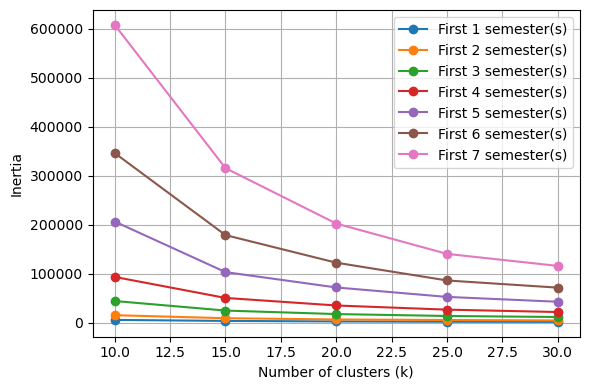

In [39]:
sorted_semesters = sorted(set(df.iloc[:, 3]))
k_range = range(10, 31, 5)

all_inertias = {}  # {n: (k_vals, inertias)}

for n in range(1, 8):   # first n semesters
    training_semesters = sorted_semesters[:n]

    k_vals, inertias = elbow_inertia(
        training_semesters,
        KMeans,
        k_range=k_range
    )

    all_inertias[n] = inertias


# Plot elbow
plt.figure(figsize=(6, 4))

for n, inertias in all_inertias.items():
    plt.plot(
        k_vals,
        inertias,
        marker='o',
        label=f'First {n} semester(s)'
    )

plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
# plt.title("Elbow Method for Different Training Semester Sizes")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig('elbow_method.eps', bbox_inches='tight')
plt.show()

In [79]:
model_predictions = {}

In [80]:
predictions = predict(recommendations.sim_distance, KMeans)
model_predictions['Euclidean Distance'] = predictions


---> Running Adaptive Framework for k=10...
  Sem 1 Done. Silhouette Score: 0.506
  Sem 2 Done. Silhouette Score: 0.476
  Sem 3 Done. Silhouette Score: 0.470
  Sem 4 Done. Silhouette Score: 0.449
  Sem 5 Done. Silhouette Score: 0.482
  Sem 6 Done. Silhouette Score: 0.496
  Sem 7 Done. Silhouette Score: 0.493

---> Running Adaptive Framework for k=15...
  Sem 1 Done. Silhouette Score: 0.406
  Sem 2 Done. Silhouette Score: 0.435
  Sem 3 Done. Silhouette Score: 0.450
  Sem 4 Done. Silhouette Score: 0.443
  Sem 5 Done. Silhouette Score: 0.442
  Sem 6 Done. Silhouette Score: 0.447
  Sem 7 Done. Silhouette Score: 0.485

---> Running Adaptive Framework for k=20...
  Sem 1 Done. Silhouette Score: 0.363
  Sem 2 Done. Silhouette Score: 0.414
  Sem 3 Done. Silhouette Score: 0.404
  Sem 4 Done. Silhouette Score: 0.401
  Sem 5 Done. Silhouette Score: 0.449
  Sem 6 Done. Silhouette Score: 0.448
  Sem 7 Done. Silhouette Score: 0.412

---> Running Adaptive Framework for k=25...
  Sem 1 Done. Silhouet

In [87]:
from sklearn.metrics import mean_squared_error
import numpy as np

def analyze_coverage_and_rmse_gap(predictions_dict, k_value='20'):
    """
    CF ve Fallback performansını kıyaslar.
    Makaledeki '???' boşluklarını doldurur.
    """
    # print(f"\n--- DETAILED ANALYSIS FOR k={k_val} ---")
    
    semesters = predictions_dict[k_value]
    
    all_true = []
    all_pred = []
    all_sources = []
    
    # Tüm dönem verilerini tek havuzda topla
    for sem in semesters:
        all_true.extend(semesters[sem]['y_true'])
        all_pred.extend(semesters[sem]['y_pred'])
        all_sources.extend(semesters[sem]['sources'])
        
    total_count = len(all_sources)
    if total_count == 0: return

    # Gruplara Ayır
    cf_indices = [i for i, s in enumerate(all_sources) if s == 'CF']
    fallback_indices = [i for i, s in enumerate(all_sources) if s == 'Fallback']
    
    # 1. COVERAGE HESABI
    cf_count = len(cf_indices)
    fallback_count = len(fallback_indices)
    coverage_ratio = (cf_count / total_count) * 100
    
    print(f"Total Predictions: {total_count}")
    print(f"CF Predictions:    {cf_count} ({coverage_ratio:.2f}%)")
    print(f"Fallback (GPA):    {fallback_count} ({100-coverage_ratio:.2f}%)")
    print("-" * 30)
    
    # 2. RMSE KIYASLAMASI (Value beyond simple GPA)
    cf_rmse = 0
    fallback_rmse = 0
    rmse_diff = 0
    
    if cf_indices:
        y_true_cf = [all_true[i] for i in cf_indices]
        y_pred_cf = [all_pred[i] for i in cf_indices]
        cf_rmse = np.sqrt(mean_squared_error(y_true_cf, y_pred_cf))
        print(f"✅ CF Model RMSE:      {cf_rmse:.4f}")
        
    if fallback_indices:
        y_true_fb = [all_true[i] for i in fallback_indices]
        y_pred_fb = [all_pred[i] for i in fallback_indices]
        fallback_rmse = np.sqrt(mean_squared_error(y_true_fb, y_pred_fb))
        print(f"⚠️ Fallback (GPA) RMSE: {fallback_rmse:.4f}")
        
    if cf_indices and fallback_indices:
        rmse_diff = fallback_rmse - cf_rmse
        print("-" * 30)
        print(f"RESULT: Fallback error is higher by {rmse_diff:.4f}")
        print(f"PROOF: CF reduces error by {(rmse_diff/fallback_rmse)*100:.1f}% compared to GPA extrapolation.")

# --- KULLANIM ---
# predictions = predict(...) kodunu çalıştırdıktan sonra:
# Eğer anahtarın adı 'Euclidean Distance' ise:
analyze_coverage_and_rmse_gap(model_predictions['Euclidean Distance'], k_value='15')

Total Predictions: 20740
CF Predictions:    13428 (64.74%)
Fallback (GPA):    7312 (35.26%)
------------------------------
✅ CF Model RMSE:      1.0119
⚠️ Fallback (GPA) RMSE: 1.0242
------------------------------
RESULT: Fallback error is higher by 0.0124
PROOF: CF reduces error by 1.2% compared to GPA extrapolation.


Mean silhouette for k = 15 euclideanUser === 0.450

In [81]:
predictions = predict(recommendations.sim_jaccard, KMeans)
model_predictions['Jaccard Index'] = predictions


---> Running Adaptive Framework for k=10...
  Sem 1 Done. Silhouette Score: 0.490
  Sem 2 Done. Silhouette Score: 0.471
  Sem 3 Done. Silhouette Score: 0.476
  Sem 4 Done. Silhouette Score: 0.464
  Sem 5 Done. Silhouette Score: 0.490
  Sem 6 Done. Silhouette Score: 0.483
  Sem 7 Done. Silhouette Score: 0.495

---> Running Adaptive Framework for k=15...
  Sem 1 Done. Silhouette Score: 0.459
  Sem 2 Done. Silhouette Score: 0.478
  Sem 3 Done. Silhouette Score: 0.441
  Sem 4 Done. Silhouette Score: 0.463
  Sem 5 Done. Silhouette Score: 0.441
  Sem 6 Done. Silhouette Score: 0.470
  Sem 7 Done. Silhouette Score: 0.450

---> Running Adaptive Framework for k=20...
  Sem 1 Done. Silhouette Score: 0.400
  Sem 2 Done. Silhouette Score: 0.408
  Sem 3 Done. Silhouette Score: 0.400
  Sem 4 Done. Silhouette Score: 0.426
  Sem 5 Done. Silhouette Score: 0.429
  Sem 6 Done. Silhouette Score: 0.447
  Sem 7 Done. Silhouette Score: 0.449

---> Running Adaptive Framework for k=25...
  Sem 1 Done. Silhouet

Mean silhouette for k = 15 jaccardUser === 0.450

In [82]:
predictions = predict(recommendations.sim_pearson, KMeans)
model_predictions['Pearson Correlation'] = predictions


---> Running Adaptive Framework for k=10...
  Sem 1 Done. Silhouette Score: 0.452
  Sem 2 Done. Silhouette Score: 0.504
  Sem 3 Done. Silhouette Score: 0.483
  Sem 4 Done. Silhouette Score: 0.457
  Sem 5 Done. Silhouette Score: 0.482
  Sem 6 Done. Silhouette Score: 0.484
  Sem 7 Done. Silhouette Score: 0.546

---> Running Adaptive Framework for k=15...
  Sem 1 Done. Silhouette Score: 0.399
  Sem 2 Done. Silhouette Score: 0.484
  Sem 3 Done. Silhouette Score: 0.460
  Sem 4 Done. Silhouette Score: 0.461
  Sem 5 Done. Silhouette Score: 0.451
  Sem 6 Done. Silhouette Score: 0.463
  Sem 7 Done. Silhouette Score: 0.456

---> Running Adaptive Framework for k=20...
  Sem 1 Done. Silhouette Score: 0.390
  Sem 2 Done. Silhouette Score: 0.441
  Sem 3 Done. Silhouette Score: 0.439
  Sem 4 Done. Silhouette Score: 0.430
  Sem 5 Done. Silhouette Score: 0.457
  Sem 6 Done. Silhouette Score: 0.441
  Sem 7 Done. Silhouette Score: 0.467

---> Running Adaptive Framework for k=25...
  Sem 1 Done. Silhouet

Mean silhouette for k = 15 pearsonUser === 0.448

In [83]:
with open('clustering_user_based_collaborative_filtering_WE_results (Student based with KMeans).json', 'w') as fw:
    json.dump(model_predictions, fw)

### Item-based Collaborative Filtering

In [100]:
model_predictions = {}

In [101]:
predictions = predict(recommendations.sim_distance, KMeans, item_based=True)
model_predictions['Euclidean Distance'] = predictions


---> Running Adaptive Framework for k=5...
  Sem 1 Done. Silhouette Score: 0.563
  Sem 2 Done. Silhouette Score: 0.597
  Sem 3 Done. Silhouette Score: 0.548
  Sem 4 Done. Silhouette Score: 0.551
  Sem 5 Done. Silhouette Score: 0.543
  Sem 6 Done. Silhouette Score: 0.584
  Sem 7 Done. Silhouette Score: 0.597

---> Running Adaptive Framework for k=15...
  Sem 1 Done. Silhouette Score: 0.391
  Sem 2 Done. Silhouette Score: 0.444
  Sem 3 Done. Silhouette Score: 0.460
  Sem 4 Done. Silhouette Score: 0.451
  Sem 5 Done. Silhouette Score: 0.441
  Sem 6 Done. Silhouette Score: 0.458
  Sem 7 Done. Silhouette Score: 0.485

---> Running Adaptive Framework for k=35...
  Sem 1 Done. Silhouette Score: 0.397
  Sem 2 Done. Silhouette Score: 0.366
  Sem 3 Done. Silhouette Score: 0.363
  Sem 4 Done. Silhouette Score: 0.429
  Sem 5 Done. Silhouette Score: 0.436
  Sem 6 Done. Silhouette Score: 0.435
  Sem 7 Done. Silhouette Score: 0.424

---> Running Adaptive Framework for k=40...
  Sem 1 Done. Silhouett

Mean silhouette for k = 15 euclideanItem === 0.456

In [76]:
predictions = predict(recommendations.sim_jaccard, KMeans, item_based=True)
model_predictions['Jaccard Index'] = predictions


---> Running Adaptive Framework for k=10...
  Sem 1 Done. Silhouette Score: 0.487
  Sem 2 Done. Silhouette Score: 0.483
  Sem 3 Done. Silhouette Score: 0.451
  Sem 4 Done. Silhouette Score: 0.481
  Sem 5 Done. Silhouette Score: 0.489
  Sem 6 Done. Silhouette Score: 0.479
  Sem 7 Done. Silhouette Score: 0.482

---> Running Adaptive Framework for k=15...
  Sem 1 Done. Silhouette Score: 0.432
  Sem 2 Done. Silhouette Score: 0.426
  Sem 3 Done. Silhouette Score: 0.457
  Sem 4 Done. Silhouette Score: 0.451
  Sem 5 Done. Silhouette Score: 0.457
  Sem 6 Done. Silhouette Score: 0.468
  Sem 7 Done. Silhouette Score: 0.472

---> Running Adaptive Framework for k=20...
  Sem 1 Done. Silhouette Score: 0.379
  Sem 2 Done. Silhouette Score: 0.442
  Sem 3 Done. Silhouette Score: 0.443
  Sem 4 Done. Silhouette Score: 0.455
  Sem 5 Done. Silhouette Score: 0.427
  Sem 6 Done. Silhouette Score: 0.436
  Sem 7 Done. Silhouette Score: 0.453

---> Running Adaptive Framework for k=25...
  Sem 1 Done. Silhouet

Mean silhouette for k = 15 jaccardItem === 0.440

In [77]:
predictions = predict(recommendations.sim_pearson, KMeans, item_based=True)
model_predictions['Pearson Correlation'] = predictions


---> Running Adaptive Framework for k=10...
  Sem 1 Done. Silhouette Score: 0.420
  Sem 2 Done. Silhouette Score: 0.482
  Sem 3 Done. Silhouette Score: 0.440
  Sem 4 Done. Silhouette Score: 0.457
  Sem 5 Done. Silhouette Score: 0.474
  Sem 6 Done. Silhouette Score: 0.485
  Sem 7 Done. Silhouette Score: 0.490

---> Running Adaptive Framework for k=15...
  Sem 1 Done. Silhouette Score: 0.392
  Sem 2 Done. Silhouette Score: 0.431
  Sem 3 Done. Silhouette Score: 0.423
  Sem 4 Done. Silhouette Score: 0.421
  Sem 5 Done. Silhouette Score: 0.438
  Sem 6 Done. Silhouette Score: 0.465
  Sem 7 Done. Silhouette Score: 0.476

---> Running Adaptive Framework for k=20...
  Sem 1 Done. Silhouette Score: 0.384
  Sem 2 Done. Silhouette Score: 0.434
  Sem 3 Done. Silhouette Score: 0.403
  Sem 4 Done. Silhouette Score: 0.456
  Sem 5 Done. Silhouette Score: 0.444
  Sem 6 Done. Silhouette Score: 0.445
  Sem 7 Done. Silhouette Score: 0.447

---> Running Adaptive Framework for k=25...
  Sem 1 Done. Silhouet

Mean silhouette for k = 15 pearsonItem === 0.462

In [78]:
with open('clustering_item_based_collaborative_filtering_results (Student based with KMeans).json', 'w') as fw:
    json.dump(model_predictions, fw)

In [102]:
with open('k_testi.json', 'w') as fw:
    json.dump(model_predictions, fw)